# SPADE VAE-GAN

In this tutorial, we apply SPADE, a VAE-GAN-based neural network developed by Park et al. [1] that performs semantic image synthesis. We apply to DRIVE DATASET

[1] Park, T., Liu, M.-Y., Wang, T.-C., & Zhu, J.-Y. (2019). Semantic Image Synthesis with Spatially-Adaptive Normalization. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition.

## Setup environment 

In [1]:
#!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
#!python -c "import matplotlib" || pip install -q matplotlib
#!python -c "import gdown" || pip install -q gdown
#%matplotlib inline


####!pip install monai==1.4.0
####!pip install lpips
####!pip install nibabel
####!pip install 'monai[all]'

In [ ]:
import os
import tempfile
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import gdown
import monai
from monai.config import print_config
from monai.utils import set_determinism
from monai.data import DataLoader
from monai.networks.nets import SPADENet, MultiScalePatchDiscriminator
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from tqdm import tqdm
from monai.transforms import Transform, Compose, Resize, ScaleIntensity, ToTensor, RandAdjustContrast, RandGaussianNoise, RandAffine
from PIL import Image
#print_config()
set_determinism(42)

#!pip install --upgrade monai nibabel

## Split data and create dictionaries

In [ ]:
root_dir = '../datasets/DRIVE_dataset/datasets/training'
print("directory used: %s " % root_dir)

Temporary directory used: ../DRIVE_dataset/datasets/training 


In [ ]:
### split dataset e dict
images_dir = '../datasets/DRIVE_dataset/datasets/training/images'
labels_dir = '../datasets/DRIVE_dataset/datasets/training/1st_manual'

# List all images and labels
all_images = sorted([os.path.join(images_dir, i) for i in os.listdir(images_dir)])
all_labels = sorted([os.path.join(labels_dir, i) for i in os.listdir(labels_dir)])

# Create data dictionaries
input_dict = [{'img': img, 'mask': lbl} for img, lbl in zip(all_images, all_labels)]

# Optionally shuffle and split the data
np.random.shuffle(input_dict)
split_point = int(len(input_dict) * 0.8)
input_dict_train = input_dict[:split_point]
input_dict_val = input_dict[split_point:]

In [178]:
# INPUT PARAMETERS
input_shape = [128, 128]
batch_size = 4
num_workers = 8
max_epochs = 200
lambda_perc = 0.9
lambda_feat = 0.2
lambda_kld = 0.001
loss_adv = 1.0

# for bce loss
lambda_bce = 1.0

## Prepare dataloaders

In [ ]:
class LoadVesselData(Transform):
    def __init__(self, output_size=(128, 128), add_channel=True, augmentations=None):
        self.output_size = output_size
        self.add_channel = add_channel
        self.augmentations = augmentations if augmentations else []

    def __call__(self, data):
        data = data.copy()
        img_input = data['img']
        mask_input = data.get('mask', None)

        # Process image only if it is a file path, otherwise assume it's already loaded
        if isinstance(img_input, str):
            image = Image.open(img_input).convert('L')
            image = image.resize(self.output_size, resample=Image.Resampling.NEAREST)
            image = np.array(image, dtype=np.float32) / 255.0  # Normalize and cast to float32
        else:
            image = img_input  # already loaded

        if self.add_channel and image.ndim == 2:
            image = np.expand_dims(image, axis=0)  # Add channel dimension [1, H, W]

        # Apply augmentations if any
        if self.augmentations:
            image = torch.from_numpy(image)
            for transform in self.augmentations:
                image = transform(image)
            image = image.numpy()
        data['img'] = image

        # Process mask if available
        if mask_input:
            if isinstance(mask_input, str):
                mask = Image.open(mask_input).convert('L')
                mask = mask.resize(self.output_size, resample=Image.Resampling.NEAREST)
                mask = np.array(mask, dtype=np.uint8)
                mask = np.where(mask > 128, 1, 0)
            else:
                mask = mask_input
            if self.add_channel and mask.ndim == 2:
                mask = np.expand_dims(mask, axis=0)
            data['mask'] = mask

        return data


augmentations = [
    #RandAdjustContrast(prob=0.33, gamma=(0.9, 1.1)),
    RandGaussianNoise(prob=0.33, mean=0.0, std=0.01),
    #RandAffine(prob=0.33, rotate_range=(-0.05, 0.05), shear_range=(0.01, 0.05), scale_range=(0, 0.05), mode='nearest', padding_mode='zeros')
]

# Using 'LoadVesselData' with integrated augmentations
train_transforms = Compose([
    LoadVesselData(output_size=(128, 128), add_channel=True, augmentations=augmentations),
    ToTensor()
])

val_transforms = Compose([
    LoadVesselData(output_size=(128, 128), add_channel=True),
    ToTensor()
])

# Assume 'input_dict_train' and 'input_dict_val' are defined using build_dict_vessels
train_dataset = monai.data.Dataset(data=input_dict_train, transform=train_transforms)
val_dataset = monai.data.Dataset(data=input_dict_val, transform=val_transforms)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


torch.Size([4, 1, 128, 128])


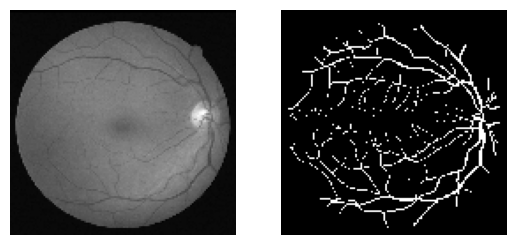

In [181]:
# Sanity check
batch = next(iter(train_loader))
print(batch["img"].shape)
plt.subplot(1, 2, 1)
plt.imshow(batch["img"][0, 0, ...], cmap="gist_gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(batch["mask"][0, 0, ...], cmap="gist_gray")
plt.axis("off")
plt.show()

### Networks creation and losses

In [182]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [183]:
def one_hot(input_label, label_nc):
    """
    One-hot encoding (label_nc=2)
    0	[1, 0] (background)
    1	[0, 1] (vessel)
    # One hot encoding function for the labels
    """

    shape_ = list(input_label.shape)
    shape_[1] = label_nc
    label_out = torch.zeros(shape_)
    for channel in range(label_nc):
        label_out[:, channel, ...] = input_label[:, 0, ...] == channel
    return label_out

In [184]:
def picture_results(input_label, input_image, output_image):
    plt.figure(figsize=(4, 1.5))
    plt.subplot(1, 3, 1)
    plt.imshow(torch.argmax(input_label, 1)[0, ...].detach().cpu(), cmap="jet")
    plt.axis("off")
    plt.title("Label")
    plt.subplot(1, 3, 2)
    plt.imshow(input_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Input image")
    plt.subplot(1, 3, 3)
    plt.imshow(output_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Output image")
    plt.show()

We define the KLD loss that we need to ensure that the latent space is Gaussian distributed [4].

[4] Kingma, D. P., & Welling, M. (2014). Auto-Encoding Variational Bayes. CoRR, abs/1312.6.

In [185]:
class KLDLoss(torch.nn.Module):
    """
    Computes the Kullback-Leibler divergence between a normal distribution with mean mu and variance logvar and
     one with mean 0 and variance 1.
    """

    def forward(self, mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

The SPADE paper includes a feature loss which acts like a regulariser of the discriminator. 

In [186]:
def feature_loss(input_features_disc_fake, input_features_disc_real, lambda_feat, device):
    criterion = torch.nn.L1Loss()
    num_d = len(input_features_disc_fake)
    gan_feat_loss = torch.zeros(1).to(device)
    for i in range(num_d):  # for each discriminator
        num_intermediate_outputs = len(input_features_disc_fake[i])
        for j in range(num_intermediate_outputs):  # for each layer output
            unweighted_loss = criterion(input_features_disc_fake[i][j], input_features_disc_real[i][j].detach())
            gan_feat_loss += unweighted_loss * lambda_feat / num_d
    return gan_feat_loss

SPADE can be used as a GAN, for which only a decoder is necessary, or a VAE-GAN, which includes an image ("style") encoder. The decoder incorporates special normalisation blocks called "SPADE" blocks. They take the semantic map and obtain rich features to normalise the activations per semantic layer.

In [ ]:
label_nc = 2

net = SPADENet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    label_nc=label_nc,
    input_shape=input_shape,
    channels=[16, 32, 64],
    z_dim=8,
    is_vae=True,
)

SPADE is trained as a GAN network, and therefore, requires a discriminator. In Park's paper, a multi-scale patch-GAN discriminator is used.

In [170]:
discriminator = MultiScalePatchDiscriminator(
    num_d=2,
    num_layers_d=3,
    spatial_dims=2,
    channels=8,
    in_channels=label_nc+1,
    out_channels=label_nc+1,
    minimum_size_im=128,
    norm="INSTANCE",
    kernel_size=3,
)

adversarial_loss = PatchAdversarialLoss(reduction="sum", criterion="hinge")

Like in the paper, we also define a perceptual loss:

In [171]:
#!pip install lpips
#!nvidia-smi
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="vgg", is_fake_3d=False, pretrained=True)
perceptual_loss = perceptual_loss.to(device)

Tue Mar 25 21:20:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:3B:00.0 Off |                    0 |
| N/A   45C    P0             26W /   70W |    7537MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [172]:
kld_loss = KLDLoss()

# Regularization

In [173]:
optimizer_g = torch.optim.Adam(net.parameters(), lr=0.0002)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0004)

In [174]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0.0, verbose=True):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            delta (float): Minimum change to qualify as improvement.
            verbose (bool): Print when early stopping is triggered.
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss  # because lower loss is better
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


## Training the network

We train the network on the following loss: a KLD loss to normalise the latent space, the adversarial multi-scale patch-GAN loss, the regularising feature loss and the perceptual loss. The training parameters have to be defined in the following box:

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0/200
Train: kld: 107.335033 ;perceptual: 3.464868 ;generator: 9.884581 ;feature: 0.345940 ;discriminator: 1.970038 


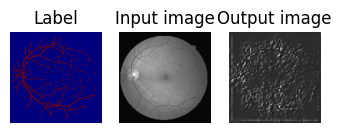

  0%|          | 1/200 [00:03<11:48,  3.56s/it]

Validation: kld: 9.775506 ;perceptual: 0.664480 ;generator: 1.977806 ;feature: 0.333670;discriminator: 3.932530 


  1%|          | 2/200 [00:06<11:10,  3.38s/it]

EarlyStopping counter: 1 / 30


  2%|▏         | 3/200 [00:10<10:54,  3.32s/it]

EarlyStopping counter: 2 / 30


  2%|▏         | 4/200 [00:13<10:45,  3.29s/it]

EarlyStopping counter: 3 / 30


  2%|▎         | 5/200 [00:16<10:40,  3.29s/it]

EarlyStopping counter: 4 / 30


  3%|▎         | 6/200 [00:19<10:39,  3.30s/it]

EarlyStopping counter: 5 / 30


  4%|▎         | 7/200 [00:23<10:36,  3.30s/it]

EarlyStopping counter: 6 / 30


  4%|▍         | 8/200 [00:26<10:34,  3.30s/it]

EarlyStopping counter: 7 / 30


  4%|▍         | 9/200 [00:29<10:33,  3.31s/it]

EarlyStopping counter: 8 / 30


  5%|▌         | 10/200 [00:33<10:33,  3.34s/it]

EarlyStopping counter: 9 / 30
Epoch 10/200
Train: kld: 55.923152 ;perceptual: 3.052271 ;generator: 13.548985 ;feature: 0.486547 ;discriminator: 1.148150 
EarlyStopping counter: 10 / 30


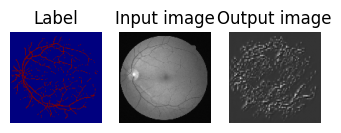

  6%|▌         | 11/200 [00:36<10:35,  3.36s/it]

Validation: kld: 5.336738 ;perceptual: 0.605274 ;generator: 2.771993 ;feature: 0.486869;discriminator: 2.254008 


  6%|▌         | 12/200 [00:39<10:28,  3.34s/it]

EarlyStopping counter: 11 / 30


  6%|▋         | 13/200 [00:43<10:26,  3.35s/it]

EarlyStopping counter: 12 / 30


  7%|▋         | 14/200 [00:46<10:21,  3.34s/it]

EarlyStopping counter: 13 / 30


  8%|▊         | 15/200 [00:50<10:19,  3.35s/it]

EarlyStopping counter: 14 / 30


  8%|▊         | 16/200 [00:53<10:10,  3.32s/it]

EarlyStopping counter: 15 / 30


  8%|▊         | 17/200 [00:57<10:34,  3.47s/it]

EarlyStopping counter: 16 / 30


  9%|▉         | 18/200 [01:00<10:20,  3.41s/it]

EarlyStopping counter: 17 / 30


 10%|▉         | 19/200 [01:03<10:12,  3.38s/it]

EarlyStopping counter: 18 / 30


 10%|█         | 20/200 [01:06<09:59,  3.33s/it]

EarlyStopping counter: 19 / 30
Epoch 20/200
Train: kld: 61.053387 ;perceptual: 2.843584 ;generator: 14.558187 ;feature: 0.475633 ;discriminator: 0.883383 
EarlyStopping counter: 20 / 30


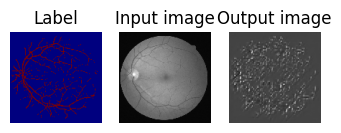

 10%|█         | 21/200 [01:10<10:02,  3.37s/it]

Validation: kld: 7.182006 ;perceptual: 0.564235 ;generator: 2.960124 ;feature: 0.504259;discriminator: 1.720437 


 11%|█         | 22/200 [01:13<09:56,  3.35s/it]

EarlyStopping counter: 21 / 30


 12%|█▏        | 23/200 [01:16<09:50,  3.34s/it]

EarlyStopping counter: 22 / 30


 12%|█▏        | 24/200 [01:20<09:45,  3.32s/it]

EarlyStopping counter: 23 / 30


 12%|█▎        | 25/200 [01:23<09:38,  3.30s/it]

EarlyStopping counter: 24 / 30


 13%|█▎        | 26/200 [01:26<09:32,  3.29s/it]

EarlyStopping counter: 25 / 30


 14%|█▎        | 27/200 [01:30<09:29,  3.29s/it]

EarlyStopping counter: 26 / 30


 14%|█▍        | 28/200 [01:33<09:27,  3.30s/it]

EarlyStopping counter: 27 / 30


 14%|█▍        | 29/200 [01:36<09:22,  3.29s/it]

EarlyStopping counter: 28 / 30


 15%|█▌        | 30/200 [01:39<09:19,  3.29s/it]

EarlyStopping counter: 29 / 30
Epoch 30/200


 15%|█▌        | 30/200 [01:43<09:45,  3.44s/it]

Train: kld: 46.801141 ;perceptual: 2.786787 ;generator: 15.283863 ;feature: 0.509780 ;discriminator: 0.746695 
EarlyStopping counter: 30 / 30
🛑 Early stopping triggered.


In [175]:
net = net.to(device)
discriminator = discriminator.to(device)
torch.autograd.set_detect_anomaly(True)
losses = {"kld": [], "perceptual": [], "feature": [], "generator": [], "discriminator": []}
losses_val = {"kld": [], "perceptual": [], "feature": [], "generator": [], "discriminator": []}
early_stopping = EarlyStopping(patience=30, delta=0.001)

for epoch in tqdm(range(max_epochs)):
    if epoch % 10 == 0:
        print("Epoch %d/%d" % (epoch, max_epochs))
    losses_epoch = {"kld": 0, "perceptual": 0, "feature": 0, "generator": 0, "discriminator": 0}
    for d in train_loader:
        image = d["img"].to(device)
        with torch.no_grad():
            label = one_hot(d["mask"], label_nc).to(device)
        optimizer_g.zero_grad()

        # Losses gen
        out, mu, logvar = net(label, image)
        kld_ = kld_loss(mu, logvar)
        disc_fakes, features_fakes = discriminator(torch.cat([out, label], 1))
        loss_g = adversarial_loss(disc_fakes, target_is_real=True, for_discriminator=False)
        disc_reals, features_reals = discriminator(torch.cat([image, label], 1))
        loss_feat = feature_loss(features_fakes, features_reals, lambda_feat, device)
        loss_perc = perceptual_loss(out, target=image)
        total_loss = loss_g + loss_perc * lambda_perc + kld_ * lambda_kld + loss_feat * lambda_feat
        total_loss.backward(retain_graph=True)
        optimizer_g.step()

        # Store
        losses_epoch["kld"] += kld_.item()
        losses_epoch["perceptual"] += loss_perc.item()
        losses_epoch["generator"] += loss_g.item()
        # Train disc
        out, _, _ = net(label, image)
        disc_fakes, _ = discriminator(torch.cat([out, label], 1))
        loss_d_r = adversarial_loss(disc_reals, target_is_real=True, for_discriminator=True)
        loss_g_f = adversarial_loss(disc_fakes, target_is_real=False, for_discriminator=True)
        optimizer_d.zero_grad()
        loss_d = loss_d_r + loss_g_f
        loss_d.backward()
        optimizer_d.step()

        # Store
        losses_epoch["feature"] = loss_feat.item()
        losses_epoch["discriminator"] = (loss_d_r.item() + loss_g_f.item()) / 2

    if epoch % 10 == 0:
        msgs = [
            f"Train: kld: {np.mean(losses_epoch['kld']):4f} ",
            f"perceptual: {np.mean(losses_epoch['perceptual']):4f} ",
            f"generator: {np.mean(losses_epoch['generator']):4f} ",
            f"feature: {np.mean(losses_epoch['feature']):4f} ",
            f"discriminator: {np.mean(losses_epoch['discriminator']):4f} ",
        ]
        print(";".join(msgs))

    losses_epoch_val = {"kld": 0, "perceptual": 0, "feature": 0, "generator": 0, "discriminator": 0}
    for d in val_loader:
        image = d["img"].to(device)
        with torch.no_grad():
            label = one_hot(d["mask"], 2).to(device)
            # Losses gen
            out, mu, logvar = net(label, image)
            kld_ = kld_loss(mu, logvar)
            disc_fakes, features_fakes = discriminator(torch.cat([out, label], 1))
            loss_g = adversarial_loss(disc_fakes, target_is_real=True, for_discriminator=False)
            disc_reals, features_reals = discriminator(torch.cat([image, label], 1))
            loss_feat = feature_loss(features_fakes, features_reals, lambda_feat, device)
            loss_perc = perceptual_loss(out, target=image)
            total_loss = loss_adv * loss_g + loss_perc * lambda_perc + kld_ * lambda_kld + loss_feat * lambda_feat
            # Store
            losses_epoch_val["kld"] += kld_.item()
            losses_epoch_val["perceptual"] += loss_perc.item()
            losses_epoch_val["generator"] += loss_g.item()
            # Train disc
            out, _, _ = net(label, image)
            disc_fakes, _ = discriminator(torch.cat([out, label], 1))
            loss_d_r = adversarial_loss(disc_reals, target_is_real=True, for_discriminator=True)
            loss_g_f = adversarial_loss(disc_fakes, target_is_real=False, for_discriminator=True)
            loss_d = loss_adv * (loss_d_r + loss_g_f)

            # Store
            losses_epoch_val["feature"] = loss_feat.item()
            losses_epoch_val["discriminator"] = loss_d_r.item() + loss_g_f.item()
            
    # Early stopping (regularization)
    val_gen_loss = losses_epoch_val["generator"] / len(val_loader)
    early_stopping(val_gen_loss)

    if early_stopping.early_stop:
        print("🛑 Early stopping triggered.")
        break


    if epoch % 10 == 0:
        picture_results(label, image, out)
        msgs = [
            f"Validation: kld: {np.mean(losses_epoch_val['kld']):4f} ",
            f"perceptual: {np.mean(losses_epoch_val['perceptual']):4f} ",
            f"generator: {np.mean(losses_epoch_val['generator']):4f} ",
            f"feature: {np.mean(losses_epoch_val['feature']):4f}",
            f"discriminator: {np.mean(losses_epoch_val['discriminator']):4f} ",
        ]
        print(";".join(msgs))

    for key, val in losses_epoch.items():
        losses[key].append(val / len(train_loader))
    for key, val in losses_epoch_val.items():
        losses_val[key].append(val / len(val_loader))

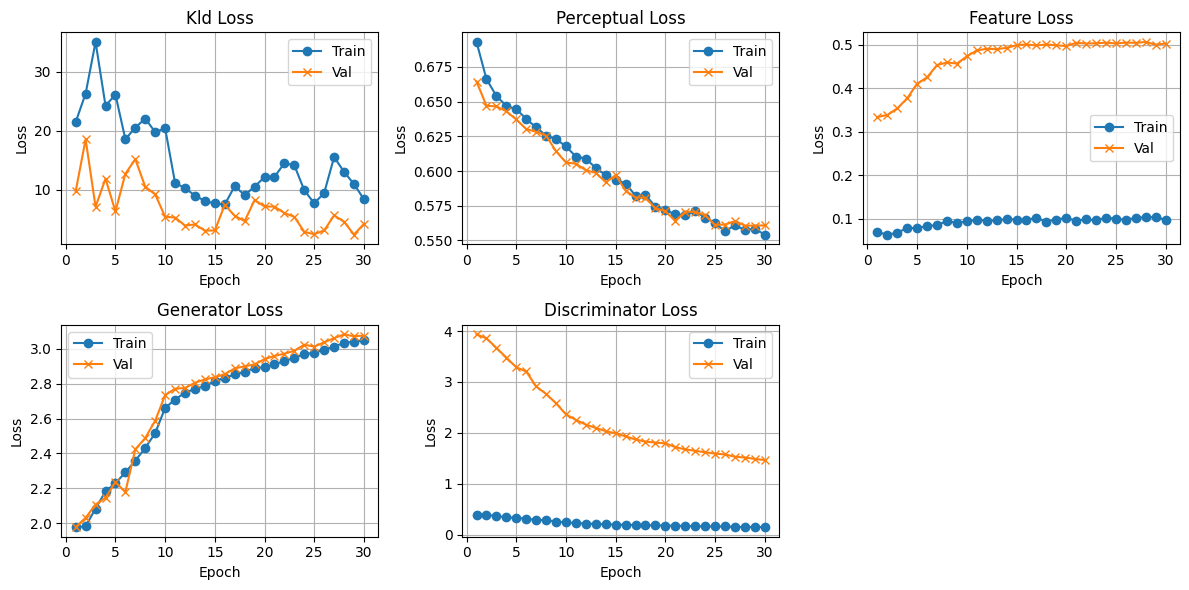

In [ ]:
def plot_losses(losses, losses_val=None):
    """
    Plots different losses over epochs.
    
    Parameters:
        losses (dict): A dictionary with keys like "kld", "perceptual", "feature", "generator", "discriminator".
                       Each value is a list of loss values (one per epoch).
        losses_val (dict, optional): A dictionary with the same keys as losses representing validation losses.
    """
    # Get the list of loss types
    loss_types = list(losses.keys())
    num_losses = len(loss_types)
    
    # Determine grid size: here we'll use 3 columns per row.
    cols = 3
    rows = (num_losses + cols - 1) // cols

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    # Flatten the axes for easy indexing
    axes = axes.flatten() if num_losses > 1 else [axes]

    epochs = range(1, len(losses[loss_types[0]]) + 1)
    
    for i, loss_name in enumerate(loss_types):
        axes[i].plot(epochs, losses[loss_name], label="Train", marker="o")
        if losses_val is not None and loss_name in losses_val:
            axes[i].plot(epochs, losses_val[loss_name], label="Val", marker="x")
        axes[i].set_title(f"{loss_name.capitalize()} Loss")
        axes[i].set_xlabel("Epoch")
        axes[i].set_ylabel("Loss")
        axes[i].legend()
        axes[i].grid(True)
    
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()

plot_losses(losses, losses_val)